# Projet 3A SN :  Détection d'activité humaine - Apprentissage supervisé et non supervisé

**Nom du Groupe :** Les zinzins de l'IA

**Noms :** Di Noia - Ben Abdallah

**Prénoms :** Lana - Aymen



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale)
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : Implémenter la DTW pour créer un système de reconnaissance;
- Partie II : Réduction de dimension par ACP et classification par kppv 
- Partie III : Classification par Forêts aléatoires
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW pour créer un système de reconnaissance;
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
3. Réduction de dimension par ACP et classification par kppv 
4. Classification par Forêts aléatoires
5. Classification par réseaux de neurones
6. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [17]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [18]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=40
TAILLE_APP=20

## 1. Création des données d'apprentissage et de test

In [15]:
# Chargement DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)




NameError: name 'N_CLASSES' is not defined

# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en CTD. 

In [ ]:
def DTW(profil_median, example_test, distance = np.linalg.norm):
    #n = np.size(profil_median)
    #m = np.size(example_test)
    n = len(profil_median)
    m = len(example_test)
    g = np.zeros((n + 1, m + 1))
    for j in range(m + 1):
        for i in range(n + 1):
            g[i][j] = np.inf
    g[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            g[i][j] = min(g[i-1][j], g[i-1][j-1], g[i][j-1]) + distance(example_test[j - 1] - profil_median[i - 1])
    
    S = g[len(profil_median) - 1, len(example_test) - 1] / (len(example_test) + len(profil_median))

    return g, S

In [ ]:
# Test de validité de la fonction implantée
A=np.array([1, 2, 3])
B=np.array([2, 2, 2, 3, 4])
C = np.array([[ 0., np.inf, np.inf, np.inf, np.inf, np.inf],
       [np.inf,  1.,  2.,  3.,  5.,  8.],
       [np.inf,  1.,  1.,  1.,  2.,  4.],
       [np.inf,  2.,  2.,  2.,  1.,  2.]])
score = 0.25
resultat = DTW(A, B)
np.testing.assert_array_equal(resultat[0], C, "Erreur dans l'implémentation de la fonction DTW!\nRésultats non cohérents avec les tests\n")
assert score == resultat[1]

2. Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes




In [ ]:
# matchPrelClass est une variable qui associe chaque prélèvement (son indice dans data_convoluted) 
# avec sa classe correspendante selon le score minimal reçu avec la fonction DTW
matchPrelClass= []
for num in range(TAILLE_TEST*N_CLASSES):
    score = np.inf
    for i in range(N_CLASSES):
        val = int(List_Data_Test[num])
        result = DTW(profil_median[i, :, :], data_convoluted[val, :, :])
        if (score > result[1]):
            score = result[1]
            classe = i
    matchPrelClass.append(classe)

In [ ]:
# On convertit matchPrelClass en un tableau pour pouvoir l'utiliser ultérieurement
match = np.array(matchPrelClass)

3. A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cmDTW = confusion_matrix(Label_Test, match)
rateDTW = (cmDTW[0,0] + cmDTW[1,1] + cmDTW[2,2])/(Data_Test.shape[0])
print(cmDTW, "\nTaux avec la DTW = ", rateDTW)

[[34  5  1]
 [21 19  0]
 [ 2  4 34]] 
Taux avec la DTW =  0.725


# Partie II : Réduction de dimension par ACP et classification par kppv 

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.




### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components = 3)
pca.fit(Data_App)
axes = pca.singular_values_

DataApp = np.dot(Data_App.reshape(Data_App.shape[0],Data_App.shape[1]//3,3), axes.transpose())
DataTest = np.dot(Data_Test.reshape(Data_Test.shape[0],Data_Test.shape[1]//3,3), axes.transpose())

### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.






In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
k1 = KNeighborsClassifier(n_neighbors=1)
k1.fit(DataApp, Label_App)

k3 = KNeighborsClassifier(n_neighbors=3)
k3.fit(DataApp, Label_App)

k5 = KNeighborsClassifier(n_neighbors=5)
k5.fit(DataApp, Label_App)


predict1 = k1.predict(DataTest)

predict3 = k3.predict(DataTest)

predict5 = k5.predict(DataTest)


cm1 = confusion_matrix(predict1, Label_Test)
taux1 = (cm1[0,0] + cm1[1,1] + cm1[2,2])/(DataTest.shape[0])

cm3 = confusion_matrix(predict3, Label_Test)
taux3 = (cm3[0,0] + cm3[1,1] + cm3[2,2])/(DataTest.shape[0])

cm5 = confusion_matrix(predict5, Label_Test)
taux5 = (cm5[0,0] + cm5[1,1] + cm5[2,2])/(DataTest.shape[0])

print(cm1, "\nTaux avec 1 voisin = ", taux1, "\n")
print(cm3, "\nTaux avec 3 voisins = ", taux3, "\n")
print(cm5, "\nTaux avec 5 voisins = ", taux5, "\n")

[[ 7 15  0]
 [ 0 12  0]
 [33 13 40]] 
Taux avec 1 voisin =  0.49166666666666664 

[[ 1 10  0]
 [ 0 10  1]
 [39 20 39]] 
Taux avec 3 voisins =  0.4166666666666667 

[[ 0  9  0]
 [ 0  7  1]
 [40 24 39]] 
Taux avec 5 voisins =  0.38333333333333336 



# Partie III : Classification par Forêts aléatoires

Les forêts aléatoires font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(DataApp, Label_App)
preds = rfc.predict(DataTest)

cm = confusion_matrix(preds, Label_Test)
taux = (cm[0,0] + cm[1,1] + cm[2,2])/(DataTest.shape[0])
print(cm, "\nTaux avec Random Forest =", taux)

[[19 13  1]
 [ 4 24  1]
 [17  3 38]] 
Taux avec Random Forest = 0.675


**Evaluation de la classification**

La performance des forêts aléatoires peut être estimée par : 
- **Accuracy score :** évaluation de la précision c'est-à-dire du nombre de données bien classées.
- **Out-of-bag estimate :**  méthode de mesure de l'erreur de prédiction des forêts aléatoires, des arbres de décision renforcés et d'autres modèles d'apprentissage utilisant l'agrégation bootstrap pour sous-échantillonner les données d'apprentissage. L'OOB est l'erreur moyenne de prédiction sur chaque échantillon d'apprentissage xᵢ, en utilisant uniquement les arbres qui n'avaient pas xᵢ dans leur échantillon bootstrap 




# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différentes solveurs

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
cNN = MLPClassifier(random_state=1, max_iter=300).fit(DataApp, Label_App)
predictNN = cNN.predict(DataTest)

cmNN = confusion_matrix(predictNN, Label_Test)
tauxNN = (cmNN[0,0] + cmNN[1,1] + cmNN[2,2])/(DataTest.shape[0])
print(cmNN, "\nTaux avec réseau de neurones =", tauxNN)

[[28 16  1]
 [ 5 20  0]
 [ 7  4 39]] 
Taux avec réseau de neurones = 0.725


# Partie V : votre étude

Réalisez votre propre étude en :
- en augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes des méthodes proposées ou en utilisant d'autres
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport. 




In [8]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [9]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'

# Data preprocessing
TIME_STEP = 60

## **   Reprise du travail précédent en pré-traitant la donnée**

Dans cette partie, nous varierons les données (taille de segment, taille de données d'apprentissage et taille de données de test) afin de prévoir le jeu de données optimal permettant d'avoir de meilleurs scores de reconnaissance

### **  1. Mise en place d'une fonction permettant de générer le jeu de donées:**

NB: on applique l'ACP sur la donnée en fin d'exécution de la fonction afin qu'on puisse directement passer à la partie d'entrainement du modèle

In [10]:
from sklearn.decomposition import PCA

In [11]:
def generer(N_CLASSES = 3, N_FEATURES = 3, SEGMENT_TIME_SIZE = 30, TAILLE_TEST = 40, TAILLE_APP = 20):

    # Chargement DATA
    data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
    data['z-axis'].replace({';': ''}, regex=True, inplace=True)
    data = data.dropna()


    data_convoluted = []
    labels = []



    # Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
    # tous les TIME_STEP pour une même activité
    for j in range(0,N_CLASSES):
        DataBest=data[data['activity'] == LABELS[j]]
        for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
            x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
            y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
            z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
            data_convoluted.append([x, y, z])
        # Label de l'activité associée à chaque segment
            label = j
            labels.append(label)


    # Conversion numpy
    data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

    labels = np.asarray(labels, dtype=np.int)



    profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
    List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Label_App=np.zeros(N_CLASSES*TAILLE_APP)

    for i in range(N_CLASSES):
        # Selection des données correspondant à la classe i
        res=np.where(labels==i)
        res=np.array(res)
        res=np.ravel(res)
        taille=res.shape[0]
        
        # Création de la base de Test
        tirage=np.random.randint(0,taille,TAILLE_TEST)
        List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
        Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
        tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
        Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
        
        
        # Création de la base d'Apprentissage
        tirage1=np.random.randint(0,taille,TAILLE_APP)
        tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
        Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
        Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
        
        # Affichage du profil temporel moyen de la classe
        class1=np.median(tir_dataApp,axis=0)
        profil_median[i,:,:]=class1

    pca = PCA(n_components = 3)
    pca.fit(Data_App)
    axes = pca.singular_values_
    DataApp = np.dot(Data_App.reshape(Data_App.shape[0],Data_App.shape[1]//3,3), axes.transpose())
    DataTest = np.dot(Data_Test.reshape(Data_Test.shape[0],Data_Test.shape[1]//3,3), axes.transpose())
    return [DataApp, DataTest, Label_App, Label_Test]

### **2. Reprise des algorithmes d'apprentissage utilisés dans les premières parties**

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [13]:
def prediction_KNN(n_neighbors = 1, weights = 'uniform', algorithm = 'auto'):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights, algorithm = algorithm)

    knn.fit(DataApp, Label_App)

    prediction = knn.predict(DataTest)

    cm = confusion_matrix(prediction, Label_Test)
    taux = (cm[0,0] + cm[1,1] + cm[2,2])/(DataTest.shape[0])

    return taux

def prediction_RFC(n_estimators = 100, criterion = 'gini', max_depth = None):
    rfc = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth)
    rfc.fit(DataApp, Label_App)
    preds = rfc.predict(DataTest)

    cm = confusion_matrix(preds, Label_Test)
    taux = (cm[0,0] + cm[1,1] + cm[2,2])/(DataTest.shape[0])

    return taux

def prediction_NN(random_state=1, max_iter=300):
    NN = MLPClassifier(random_state = random_state, max_iter = max_iter).fit(DataApp, Label_App)
    predictNN = NN.predict(DataTest)

    cm = confusion_matrix(predictNN, Label_Test)
    taux = (cm[0,0] + cm[1,1] + cm[2,2])/(DataTest.shape[0])

    return taux

### **3. Résultats de la simulation**

NB: tous les résultats seront interprétés dans le rapport joint à ce notebook


#### **3.1 Variation de la taille des données de test**

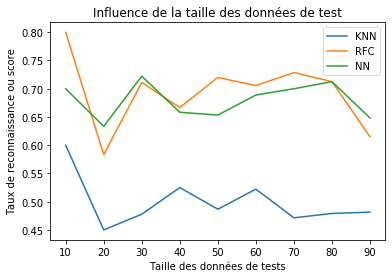

In [14]:
tauxTest = {"KNN":{}, "RFC":{}, "NN":{}}

for i in range(9):
    [DataApp, DataTest, Label_App, Label_Test] = generer(TAILLE_TEST = 10 + 10*i)
    tauxTest["KNN"][str(10 + 10*i)] = prediction_KNN()
    tauxTest["RFC"][str(10 + 10*i)] = prediction_RFC()
    tauxTest["NN"][str(10 + 10*i)] = prediction_NN()

listOrdKNN = sorted(tauxTest["KNN"].items())
listOrdRFC = sorted(tauxTest["RFC"].items())
listOrdNN = sorted(tauxTest["NN"].items())
x_KNN, y_KNN = zip(*listOrdKNN)
x_RFC, y_RFC = zip(*listOrdRFC)
x_NN, y_NN = zip(*listOrdNN)

plt.plot(x_KNN, y_KNN, label="KNN")
plt.plot(x_RFC, y_RFC, label="RFC")
plt.plot(x_NN, y_NN, label="NN")

plt.title('Influence de la taille des données de test')
plt.xlabel("Taille des données de tests")
plt.ylabel("Taux de reconnaissance ou score")
plt.legend()
plt.show()


#### **3.2 Variation de la taille des données d'entrainement

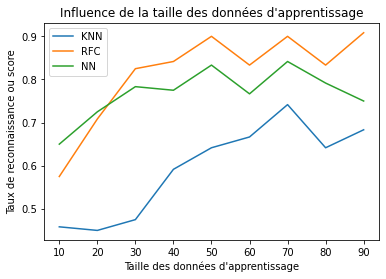

In [ ]:
tauxApp = {"KNN":{}, "RFC":{}, "NN":{}}

for i in range(9):
    [DataApp, DataTest, Label_App, Label_Test] = generer(TAILLE_APP = 10 + 10*i)
    tauxApp["KNN"][str(10 + 10*i)] = prediction_KNN()
    tauxApp["RFC"][str(10 + 10*i)] = prediction_RFC()
    tauxApp["NN"][str(10 + 10*i)] = prediction_NN()

listOrdKNN = sorted(tauxApp["KNN"].items())
listOrdRFC = sorted(tauxApp["RFC"].items())
listOrdNN = sorted(tauxApp["NN"].items())
xKNN, yKNN = zip(*listOrdKNN)
xRFC, yRFC = zip(*listOrdRFC)
xNN, yNN = zip(*listOrdNN)

plt.plot(xKNN, yKNN, label="KNN")
plt.plot(xRFC, yRFC, label="RFC")
plt.plot(xNN, yNN, label="NN")

plt.title("Influence de la taille des données d'apprentissage")
plt.xlabel("Taille des données d'apprentissage")
plt.ylabel("Taux de reconnaissance ou score")
plt.legend()
plt.show()

#### **3.3 Variation de la taille des segments**

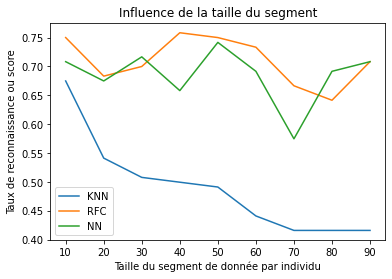

In [ ]:
tauxSeg = {"KNN":{}, "RFC":{}, "NN":{}}

for i in range(9):
    [DataApp, DataTest, Label_App, Label_Test] = generer(SEGMENT_TIME_SIZE = 10 + 10*i)
    tauxSeg["KNN"][str(10 + 10*i)] = prediction_KNN()
    tauxSeg["RFC"][str(10 + 10*i)] = prediction_RFC()
    tauxSeg["NN"][str(10 + 10*i)] = prediction_NN()

listOrdKNN = sorted(tauxSeg["KNN"].items())
listOrdRFC = sorted(tauxSeg["RFC"].items())
listOrdNN = sorted(tauxSeg["NN"].items())
x_KNN, y_KNN = zip(*listOrdKNN)
x_RFC, y_RFC = zip(*listOrdRFC)
x_NN, y_NN = zip(*listOrdNN)

plt.plot(x_KNN, y_KNN, label="KNN")
plt.plot(x_RFC, y_RFC, label="RFC")
plt.plot(x_NN, y_NN, label="NN")

plt.title("Influence de la taille du segment")
plt.xlabel("Taille du segment de donnée par individu")
plt.ylabel("Taux de reconnaissance ou score")
plt.legend()
plt.show()

#### **3.4 Variation simultannée des 3 variables**

In [ ]:
tauxAbs = {"KNN":{}, "RFC":{}, "NN":{}}


for i in range(4):
    SEGMENT_TIME_SIZE = 20 + 10*i
    for j in range(4):
        TAILLE_TEST = 10 + 10*i
        for k in range(4):
            TAILLE_APP = 30 + 10*i
            [DataApp, DataTest, Label_App, Label_Test] = generer(SEGMENT_TIME_SIZE = SEGMENT_TIME_SIZE, TAILLE_TEST = TAILLE_TEST, TAILLE_APP = TAILLE_APP)
            tauxAbs["KNN"]["Taille Segment = " + str(20 + 10*i) + ", Taille Test = " + str(10 + 10*j) + ", Taille Apprentissage = " + str(30 + 10*k)] = prediction_KNN()
            tauxAbs["RFC"]["Taille Segment = " + str(20 + 10*i) + ", Taille Test = " + str(10 + 10*j) + ", Taille Apprentissage = " + str(30 + 10*k)] = prediction_RFC()
            tauxAbs["NN"]["Taille Segment = " + str(20 + 10*i) + ", Taille Test = " + str(10 + 10*j) + ", Taille Apprentissage = " + str(30 + 10*k)] = prediction_NN()

print(tauxAbs["RFC"])
print(tauxAbs["KNN"])
print(tauxAbs["NN"])

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'Taille Segment = 20, Taille Test = 10, Taille Apprentissage = 30': 0.7333333333333333, 'Taille Segment = 20, Taille Test = 10, Taille Apprentissage = 40': 0.6666666666666666, 'Taille Segment = 20, Taille Test = 10, Taille Apprentissage = 50': 0.8666666666666667, 'Taille Segment = 20, Taille Test = 10, Taille Apprentissage = 60': 0.7, 'Taille Segment = 20, Taille Test = 20, Taille Apprentissage = 30': 0.7666666666666667, 'Taille Segment = 20, Taille Test = 20, Taille Apprentissage = 40': 0.8, 'Taille Segment = 20, Taille Test = 20, Taille Apprentissage = 50': 0.9333333333333333, 'Taille Segment = 20, Taille Test = 20, Taille Apprentissage = 60': 0.8666666666666667, 'Taille Segment = 20, Taille Test = 30, Taille Apprentissage = 30': 0.6333333333333333, 'Taille Segment = 20, Taille Test = 30, Taille Apprentissage = 40': 0.7333333333333333, 'Taille Segment = 20, Taille Test = 30, Taille Apprentissage = 50': 0.7, 'Taille Segment = 20, Taille Test = 30, Taille Apprentissage = 60': 0.666666